In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [155]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [156]:
cfg_default = dict(
    seed=0, save_dir=None,
    prompt="",
    algo="",
    rollout_steps=200,
    bs=32, n_iters=10000,
)

seed_sweep = np.arange(4)

prompt_sweep = [
    "a biological cell",
    "a biological cell under the microscope",
    "a red organism",
    "a bacterium under the microscope",
    "a diverse ecosystem of cells moving around",
    "an artificial life organism",
    "the lenia creature: Orbium",
    "a cool colorful pattern",
]

algo_sweep = ["Sep_CMA_ES"]
sigma_sweep = [0.01, 0.1, 0.5]

cfgs = []
for algo in algo_sweep:
    for seed in seed_sweep:
        for sigma in sigma_sweep:
            for iprt, prompt in enumerate(prompt_sweep):
                cfg = cfg_default.copy()
                cfg.update(seed=seed, algo=algo, prompt=prompt, sigma=sigma)
                cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_prompt2/{seed}_{algo}_{iprt}_{sigma}")
                cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

96


In [157]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_lenia_evosax.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_lenia_evosax.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_prompt2/0_Sep_CMA_ES_0_0.01" --prompt="a biological cell"                          --algo="Sep_CMA_ES" --rollout_steps=200 --bs=32 --n_iters=10000 --sigma=0.01
python train_lenia_evosax.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_prompt2/0_Sep_CMA_ES_1_0.01" --prompt="a biological cell under the microscope"     --algo="Sep_CMA_ES" --rollout_steps=200 --bs=32 --n_iters=10000 --sigma=0.01
python train_lenia_evosax.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_prompt2/0_Sep_CMA_ES_2_0.01" --prompt="a red organism"                             --algo="Sep_CMA_ES" --rollout_steps=200 --bs=32 --n_iters=10000 --sigma=0.01 
...
96 commands


# Visualize Results

In [136]:
import jax
import jax.numpy as jnp
import copy

In [137]:
df = []

for cfg in tqdm(cfgs):
    save_dir = cfg['save_dir']
    # data_dense = util.load_pkl(save_dir, 'data_dense')
    # data_dense = jax.tree.map(lambda *x: np.stack(x, axis=0), *data_dense)
    
    dfi = copy.copy(cfg)
    try:
        data = util.load_pkl(save_dir, 'data')
        loss = data['best_fitness'][-1].item()
        dfi['loss'] = loss
    except:
        pass
        
    df.append(dfi)
df = pd.DataFrame(df)

  0%|          | 0/96 [00:00<?, ?it/s]

In [138]:
df

,seed,save_dir,prompt,algo,rollout_steps,bs,n_iters,sigma,loss
0,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a biological cell,Sep_CMA_ES,200,32,10000,0.01,-0.290431
1,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a biological cell under the microscope,Sep_CMA_ES,200,32,10000,0.01,-0.262049
2,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a red organism,Sep_CMA_ES,200,32,10000,0.01,-0.292242
3,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a bacterium under the microscope,Sep_CMA_ES,200,32,10000,0.01,-0.279477
4,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a diverse ecosystem of cells moving around,Sep_CMA_ES,200,32,10000,0.01,-0.283865
...,...,...,...,...,...,...,...,...,...
91,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a bacterium under the microscope,Sep_CMA_ES,200,32,10000,0.50,-0.305651
92,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,a diverse ecosystem of cells moving around,Sep_CMA_ES,200,32,10000,0.50,-0.301317
93,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,an artificial life organism,Sep_CMA_ES,200,32,10000,0.50,-0.294779
94,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,the lenia creature: Orbium,Sep_CMA_ES,200,32,10000,0.50,-0.291482


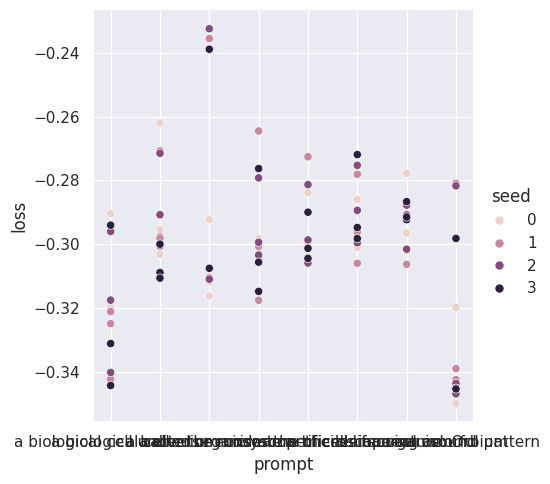

In [139]:
sns.relplot(data=df, x='prompt', y='loss', hue='seed')

In [141]:
for seed in seed_sweep:
    for sigma in sigma_sweep:
        for iprt, prompt in enumerate(prompt_sweep):
            save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_prompt2/{seed}_{algo}_{iprt}_{sigma}"

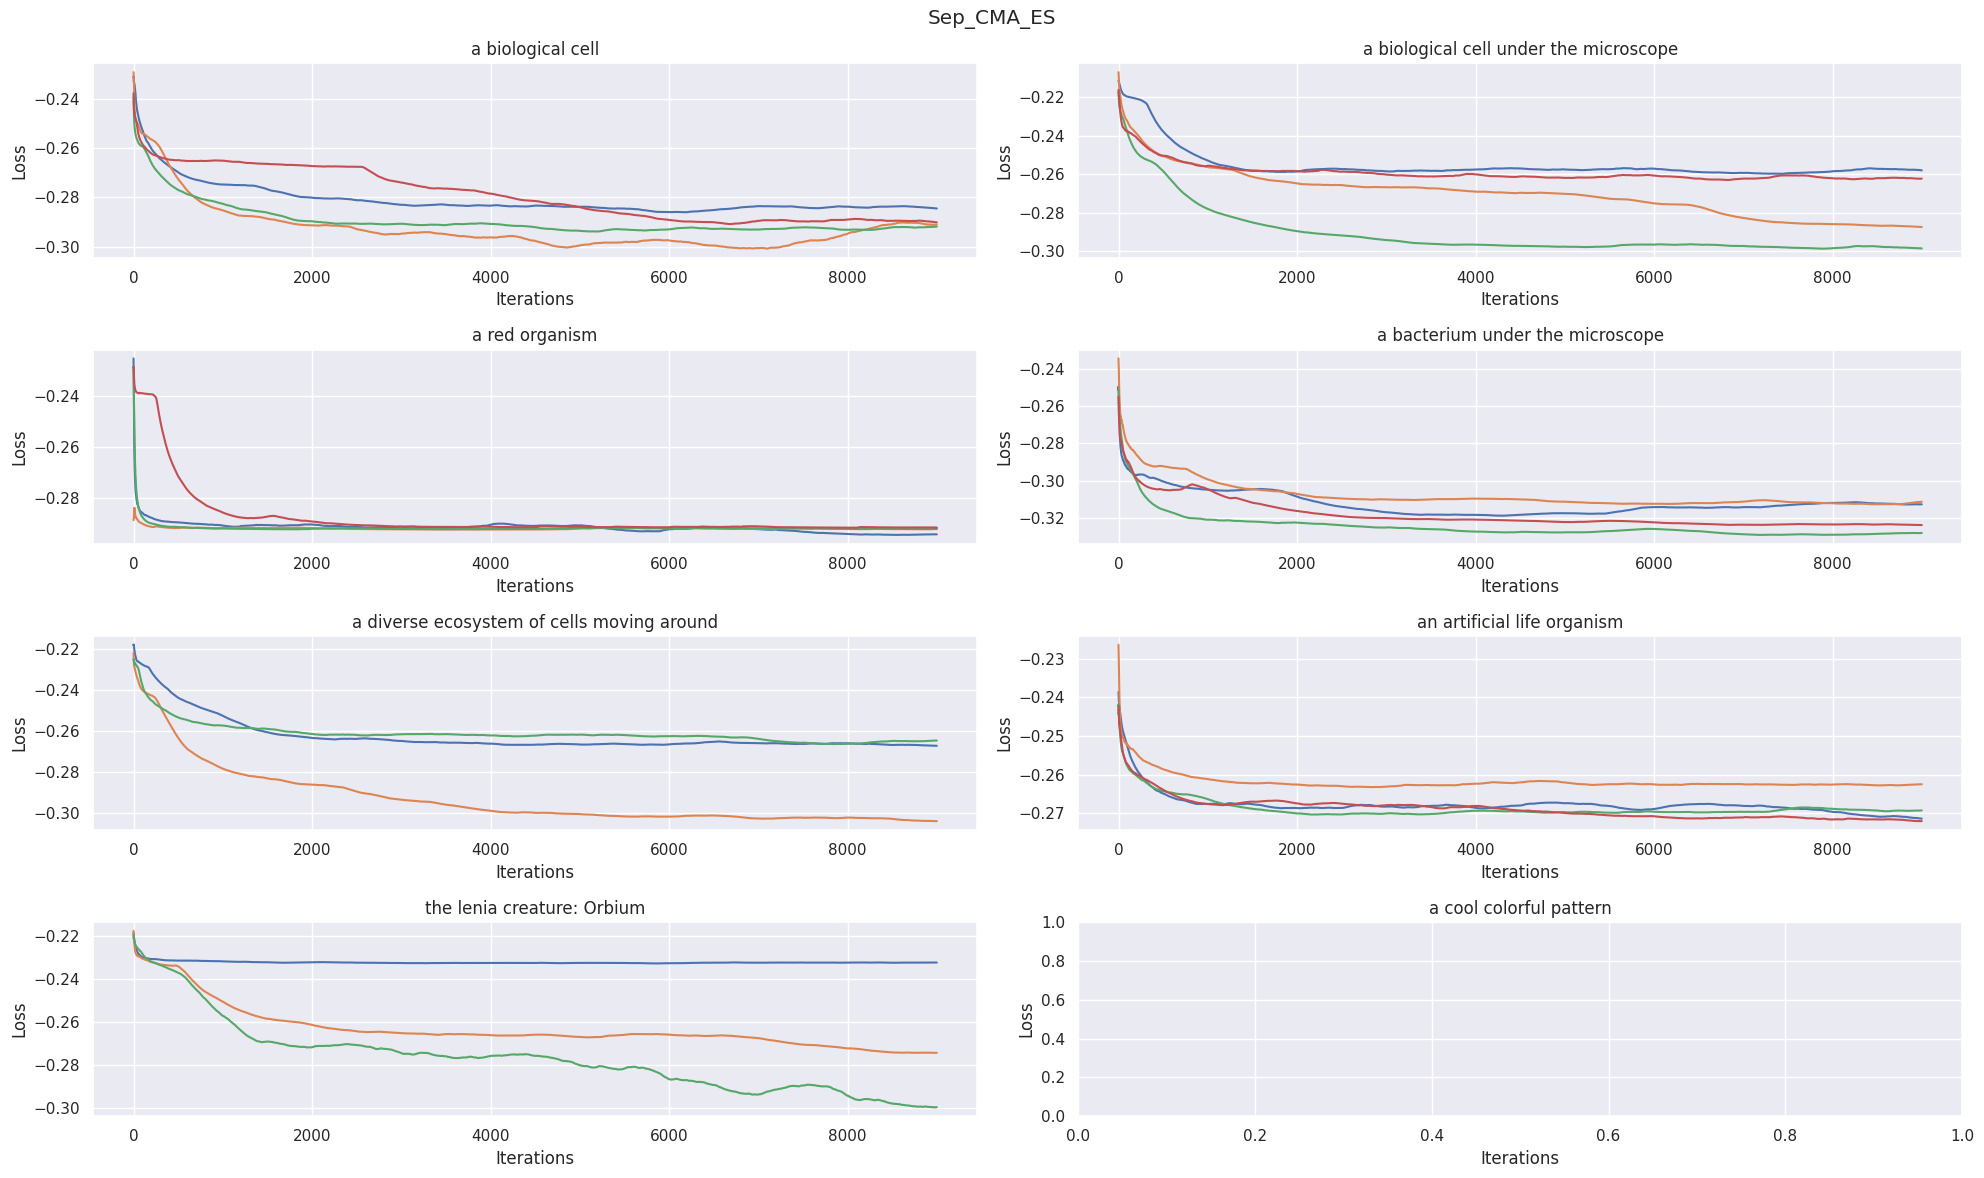

In [140]:
algo = 'Sep_CMA_ES'
plt.figure(figsize=(20, 12))
for iprt, prompt in enumerate(prompt_sweep):
    plt.subplot(4, 2, iprt+1)
    plt.title(prompt)
    for seed in seed_sweep:
        try:
            save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_prompt1/{seed}_{algo}_{iprt}"
            data = util.load_pkl(save_dir, 'data')
            loss = pd.DataFrame(data['loss'])
            plt.plot(loss.ewm(span=1000).mean())
        except:
            pass
    plt.ylabel("Loss")
    plt.xlabel("Iterations")
plt.suptitle(algo)
plt.tight_layout()
plt.show()

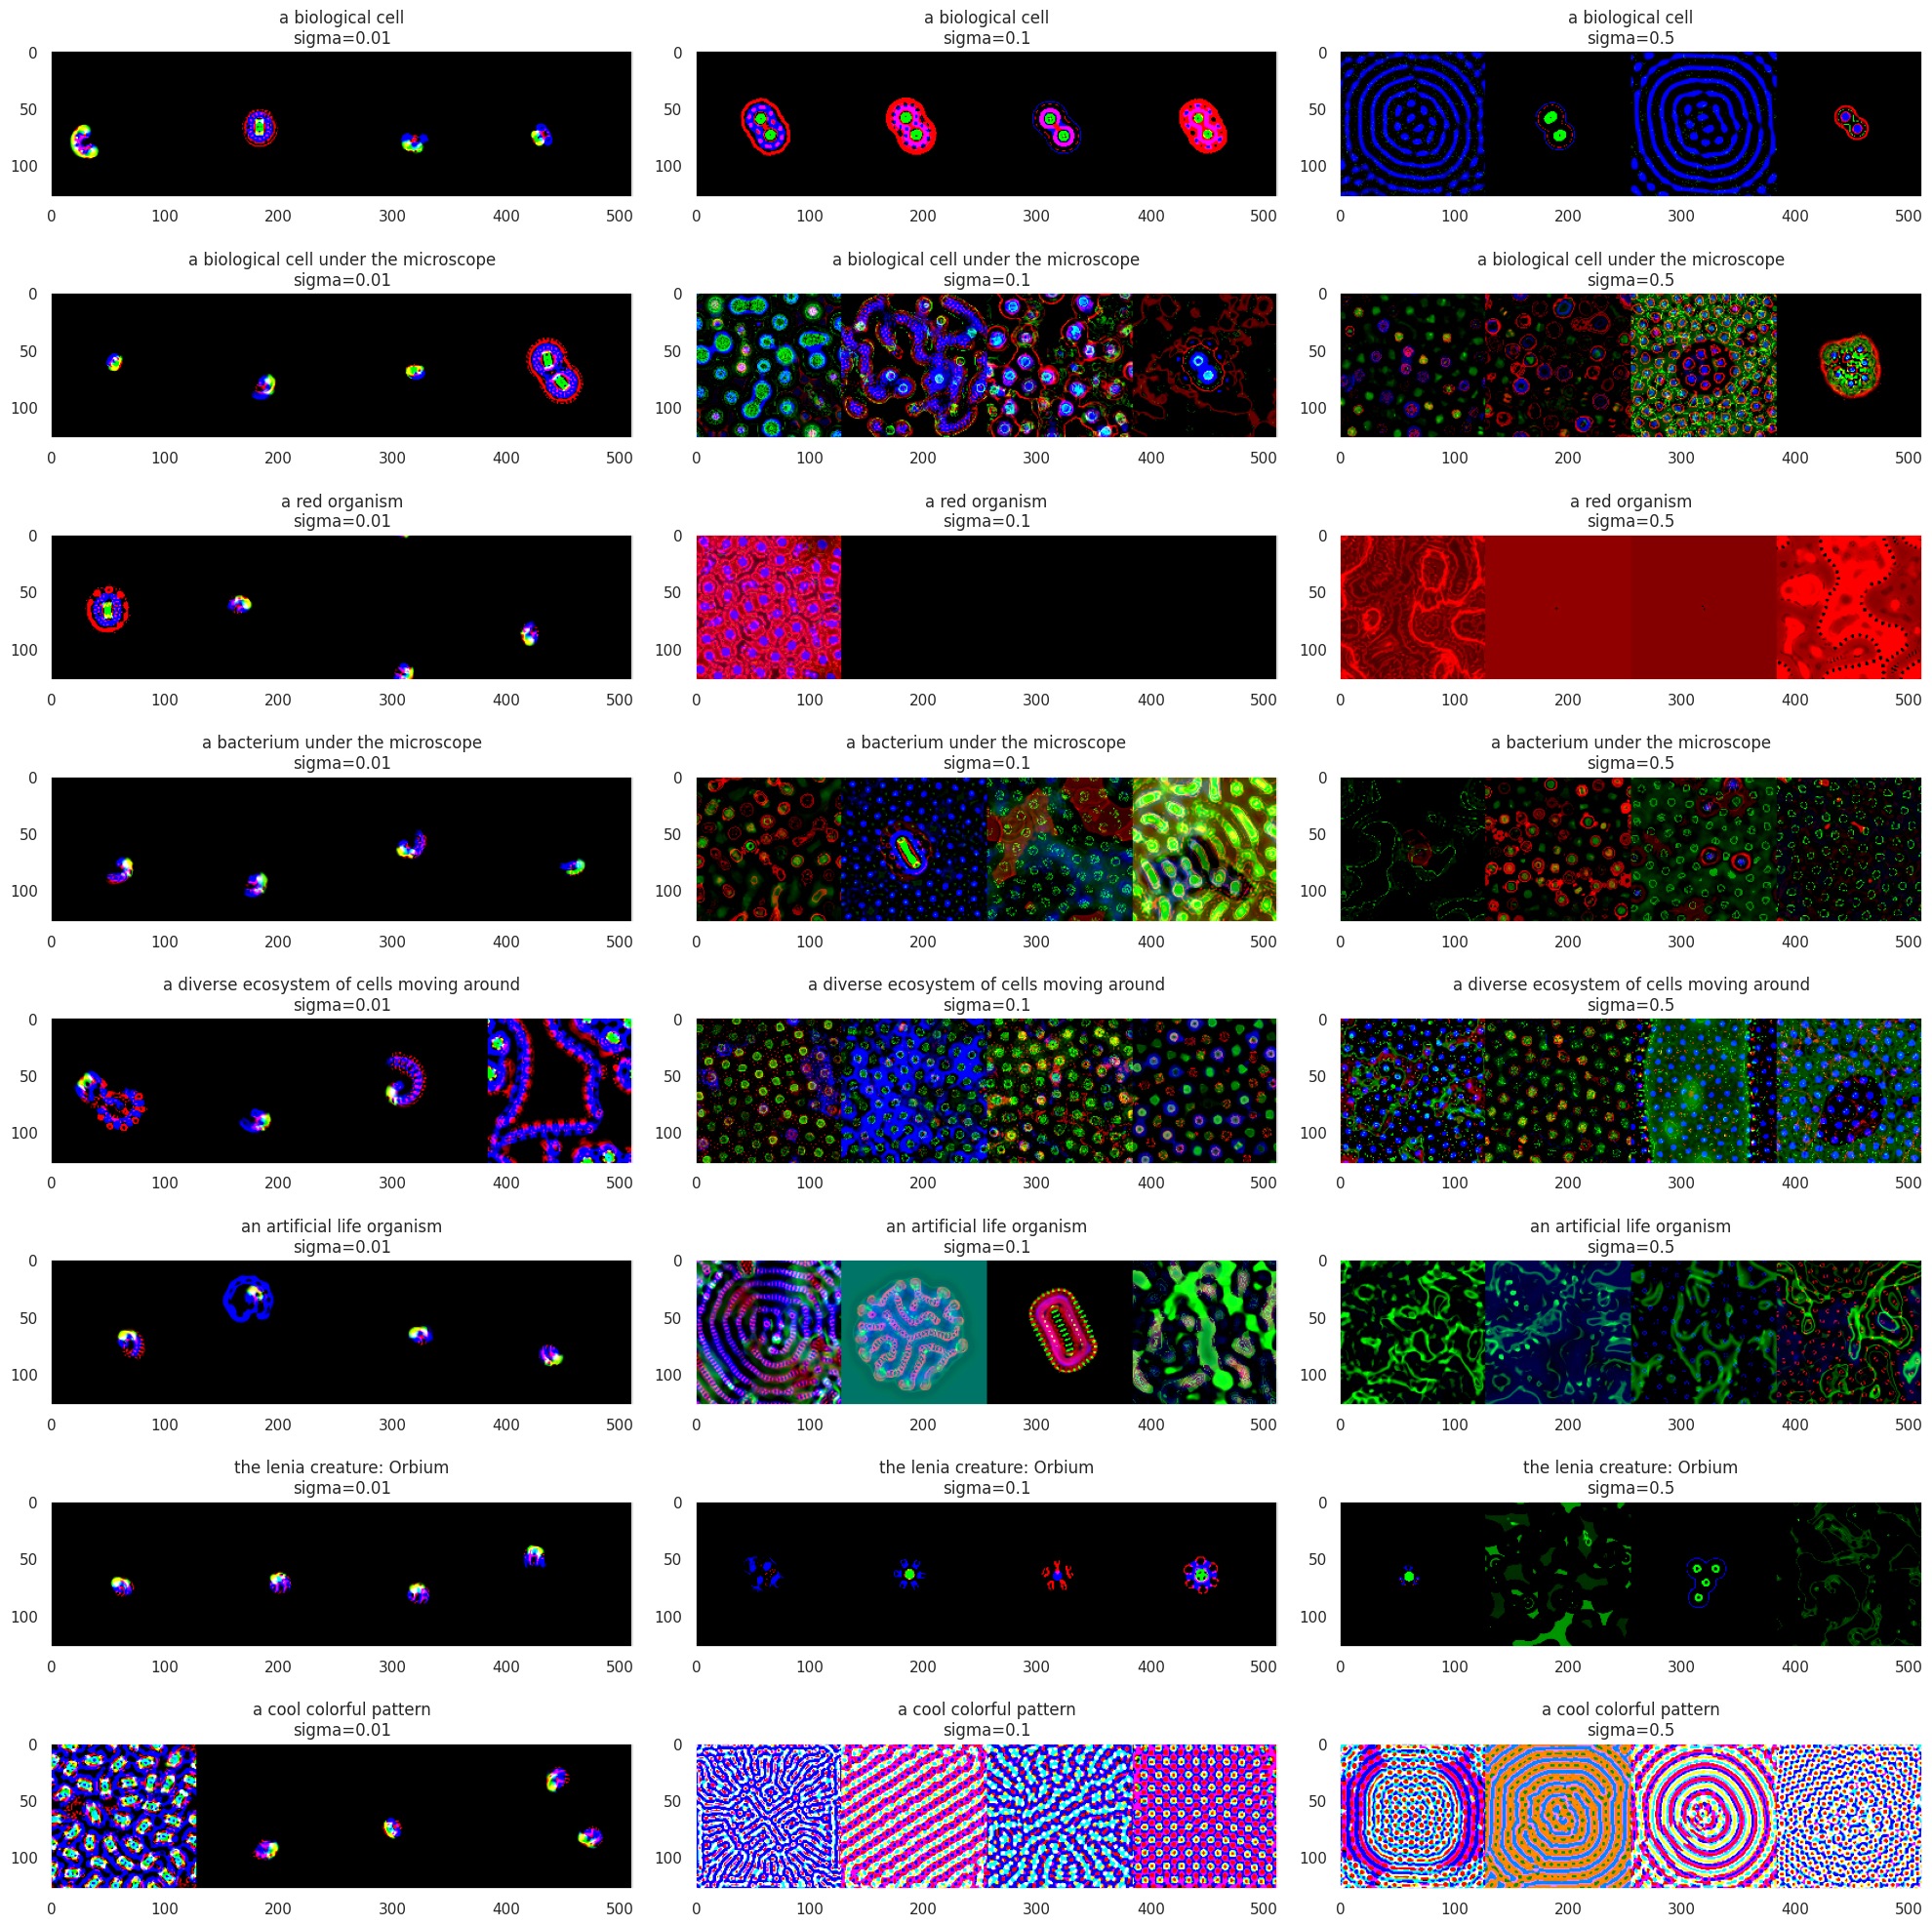

In [154]:
plt.figure(figsize=(20, 20))
iplt = 0
for iprt, prompt in enumerate(prompt_sweep):
    for sigma in sigma_sweep:
        imgs = []
        for seed in seed_sweep:
            save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_prompt2/{seed}_{algo}_{iprt}_{sigma}"
            try:
                img = util.load_pkl(save_dir, 'vid').astype(np.uint8)[-1]
            except:
                img = np.zeros((128, 128, 3), dtype=np.uint8)
            imgs.append(img)
        img = rearrange(np.stack(imgs), "(R C) H W D -> (R H) (C W) D", R=1)
        iplt += 1
        plt.subplot(8, 3, iplt)
        plt.imshow(img)
        plt.grid(False)
        plt.title(f"{prompt}\n{sigma=}")

plt.tight_layout()
plt.show()

In [147]:
len(prompt_sweep), len(sigma_sweep)

(8, 3)